# Physics-informed machine learning for the COVID-19 pandemic: <br>Adherence to social distancing and short-term predictions for eight countries

### G. D. Barmparis and G. P. Tsironis

Preprint: https://arxiv.org/abs/2008.08162v1

# Import needed packages

In [1]:
# Import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta

# Set the font size to 18pt for all the plots.
import matplotlib
matplotlib.rcParams.update({'font.size': 6})

# Machine Learning packages
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Defining the parameters.

In [2]:
# Countries. (SWt0 : First day for the second wave, since the first case in each country.) 
countries = {        "Greece" : {"SWt0" : 97},
             "United States"  : {"SWt0" : 127},
             "United Kingdom" : {"SWt0" : 134},
                    "Germany" : {"SWt0" : 160},
                     "France" : {"SWt0" : 130},
                "Netherlands" : {"SWt0" : 126},
                      "Italy" : {"SWt0" : 138},
                      "Spain" : {"SWt0" : 140}
            }

runOnly = ["Greece"] # Use 'All' to run them all!
if "All" in runOnly : runOnly = list(countries.keys())
  
# Kind of data
kind = "new_cases" # or new_deaths

# Number of days for short term predictions.
nOfShortPredDays = 7 

# Number of days for long term predictions.
nOfLongPredDays  = 4*7

# Number of days for smoothing plus minus the given date. Average on 2*nOfDaysSmoothing + 1 days.
nOfDaysSmoothing = 3 #실제 감염일과 검사일이 다를 수 있으므로 smoothing. 다만 검사일은 감염일보다 뒤에 있을 수 밖에 없는데, 앞쪽 값들도 평균에 포함시키는 것이 맞는지는 의문.
# 감염일과 검사일이 평균 얼마나 다른지 조사해볼 필요가 있음. 혹은 모델 예측 성능을 바탕으로, 어떤 smoothing이 적합한지에 따라 감염일과 검사일이 얼마나 다른지 단서가 될 수 있음.

# Number of grid-point for the SIR model.
nOfSIRPoints = 500

# Use pre-trained model.
loadModel = True

# Patience before early stopping.
patience = 50

# Display progress every "displayStep" epochs.
displayStep = 50

# Total possible number of epochs.
epochs = 50000

# Read data

In [3]:
path = "owid-covid-data.csv"
data = pd.read_csv(path)

# Define the Loss functions.

In [4]:
# Data driven mean squared error.
def loss_MSE(y_true, y_pred) :
  #
  lossMSE = tf.reduce_mean(tf.square(y_true - y_pred))
  #
  return lossMSE

# PINN-SIR loss.
def sir(model, xTrainSIR, mu):
  #
  tTensor = tf.convert_to_tensor(xTrainSIR)
  tModelA = xTrainSIR.flatten() #for example, if xTrainSIR = [[1,2,3],[4,5,6]], then xTrainSIR.flatten() = [1,2,3,4,5,6]
  #
  with tf.GradientTape() as g: #GradientTape: https://www.tensorflow.org/guide/autodiff
    g.watch(tTensor) # g.watch(tTensor) tells TensorFlow to track the gradient of tTensor with respect to the loss function.
    with tf.GradientTape() as gg:
      gg.watch(tTensor)
      x = model(tTensor)
    x_t = gg.gradient(x, tTensor)
    #
  x_tt = g.gradient(x_t, tTensor)
  #
  aa  = sigma*tModelA + sigma0
  a_t = [sigma]*len(tModelA)
  #
  del g, gg
  #
  return tf.abs(x_tt + ((sigma*tModelA + sigma0)*tf.exp(x) - sigma/(sigma*tModelA + sigma0))*(x_t + mu))**2


def loss_SIR() :
  #
  lossSIR = sir(model, xTrainSIR, mu)
  #
  return lossSIR

# Define an Early Stopping class.

In [30]:
class EarlyStopping :
  #
  def __init__(self, model, patience, displayStep, realData, trainData, tPredict) :
    #
    self.step = 0
    #
    self.fn = open(os.path.join("SecondWave_%s" % country, "%s_output" % country), "a+")
    #
    self.model = model
    #
    self.patience = patience
    #
    self.displayStep = displayStep
    self.tData, self.yData = realData
    self.tTrainData, self.yTrainData = trainData
    self.tPredict = tPredict
    #
    self.best = np.inf
    self.wait = 0
    #
    self.best_model = None
    self.best_weights = None
    self.bestSigma = None
    self.bestSigma0 = None
    self.bestM = None
    #
    self.stopped_epoch = 0
    self.stop_training = False

  def on_epoch_end(self, epoch, losses) :
    #
    mse, pi, current = losses["MSE_Data"], losses["MSE_SIR"], losses["TotLoss"]
    #
    if current < 1.e-5 :
      #
      self.stopped_epoch = epoch
      #
      self.model.set_weights(self.best_weights)
      self.model.save(os.path.join("SecondWave_%s" % country, "%s_SIR.h5" % country))
      #
      log = "Epoch %05d: early stopping. %s" % (self.stopped_epoch + 1, " ".join("%s : %12.6f " % (k,v) for k,v in losses.items()))
      #
      print(log)
      #
      self.fn.write("%s\n" % log)
      #
      self.plotBestState(epoch, dateTicks=dateTicks)
      #
      self.plotPredictions()
      #
      self.stop_training = True
      #
    else :
      #
      if np.less(current, self.best) :
        #
        self.best = current
        self.wait = 0
        #
        # Keep best weights.
        self.best_model = self.model
        self.best_weights = self.model.get_weights()
        self.bestSigma = sigma.numpy()
        self.bestSigma0 = sigma0.numpy()
        self.bestM = mu.numpy()
        #
      else :
        #
        self.wait += 1
        #
        if self.wait >= self.patience:
          #
          self.stopped_epoch = epoch
          #
          log = "Restoring model weights from the end of the best epoch."
          print(log)
          #
          self.fn.write("%s\n" % log)
          self.fn.flush()
          #
          self.model.set_weights(self.best_weights) 
          self.best_model = self.model
          #
          self.model.save(os.path.join("SecondWave_%s" % country, "%s_SIR.h5" % country))
          #
          log = "Early Stopping!\nEpoch:%6i, Loss: %12.6f, N: %i, Best parameters: sigma: %.6f, sigma0: %.6f, Mu: %.6f, R0:%.6f" % ( self.stopped_epoch + 1, self.best, N, self.bestSigma, self.bestSigma0, self.bestM, self.bestSigma0/self.bestM )
          print(log)
          #
          self.fn.write("%s\n" % log)
          self.fn.flush()
          #
          self.plotBestState(epoch, dateTicks=dateTicks)
          #
          self.plotPredictions()
          #
          self.stop_training = True
          #
    self.step += 1
    #
    if not self.stop_training : 
      #
      log = "Epoch:%6i, N: %i, %s, S: %.6f, S0: %.6f, Mu: %.6f, R0:%.6f, P:%i" % (epoch + 1, N, " ".join("%s: %12.6f " % (k,v) for k,v in losses.items()), sigma.numpy(), sigma0.numpy(), mu.numpy(), sigma0.numpy()/mu.numpy(), self.wait)
      #
      print(log)
      #
      self.fn.write("%s\n" % log)
      self.fn.flush()
      #
      if self.step == 1 or self.step%(self.displayStep) == 0 : 
        self.plotBestState(epoch, dateTicks=dateTicks)
    #
    return self.stop_training


  def plotBestState(self, epoch, dateTicks) :
    #
    fig, ax1 = plt.subplots( figsize = (18, 8) )
    #
    plt.title("%s. $\sigma$: %.6f $\sigma_0$: %.6f $\mu$: %.6f $R_0$: %.6f" % (country, self.bestSigma, self.bestSigma0, self.bestM, self.bestSigma0/self.bestM))
    #
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('I(t)', color = 'k')
    #
    # Original Data
    ax1.plot(self.tData, (N-N0)*self.yData + N0, 'go', markersize = 8, label = 'Reported data')
    #
    # Training Data
    ax1.plot(self.tTrainData, (N-N0)*np.exp(self.yTrainData) + N0, 'ro', markersize = 8, label = 'Training data')
    #
    # Predicted values at xValues PINN
    predicted_values = np.squeeze(self.best_model.predict(self.tPredict.reshape(-1, 1)))
    ax1.plot(self.tPredict, (N-N0)*np.exp(predicted_values) + N0, color = "orange", label = 'PINN')

    #
    ax1.tick_params(axis = 'y', labelcolor = "k")
    plt.legend(loc = "upper left")

    dateTicks = dateTicks[:len(tData[::7])]
    ax1.set_xticks(tData[::7])
    ax1.set_xticklabels(dateTicks)
    plt.setp(ax1.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    #
    ax1.grid()
    #
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    #
    # Plot a(t)
    color = 'tab:blue'
    ax2.set_ylabel('a(t)', color = 'b')
    #
    ax2.plot(self.tPredict, self.bestSigma*self.tPredict + self.bestSigma0 , "b-", label = "a(t)")
    ax2.plot(self.tPredict, [self.bestM]*len(self.tPredict), "k--", label = "$\mu$")
    #
    ax2.legend(loc = "upper right")
    ax2.tick_params(axis = 'y', labelcolor = 'b')
    #    
    fig.tight_layout()
    #
    plt.savefig(os.path.join("SecondWave_%s" % country, "%s_Best_%i.svg" % (country, epoch+1)),
                dpi = 300, orientation='landscape', format = 'svg')
    #
    plt.show()
    #
    plt.close()


  def plotPredictions(self) :
    #
    fig = plt.figure( figsize = (18, 8) )
    #
    plt.title("%s" % country)
    #
    color = 'tab:red'
    plt.xlabel('Date')
    plt.ylabel('I(t)', color = 'k')
    #
    # Original Data
    plt.plot(self.tData, (N-N0)*self.yData + N0, 'go', markersize = 8, label = 'Reported data')
    #
    # Predicted values during Training.
    plt.plot(self.tPredict, (N-N0)*np.exp(self.best_model.predict(self.tPredict.reshape(-1, 1))) + N0, color = "orange", label = 'PINN')

    #
    # Short Term Predictions
    tShortPred = np.linspace(nOfDays, nOfDays + nOfShortPredDays - 1, nOfShortPredDays)
    plt.plot(tShortPred, (N-N0)*np.exp(self.best_model.predict(tShortPred))+ N0, color = 'C1', marker = "o", ls = "", fillstyle = 'none', markersize = 8, label = 'Short Term Predictions')
    #
    # Long Term Predictions
    tLongPred = np.linspace(nOfDays + nOfShortPredDays, nOfDays + nOfShortPredDays + nOfLongPredDays - 1, nOfLongPredDays)
    plt.plot(tLongPred, (N-N0)*np.exp(self.best_model.predict(tLongPred))+ N0, color = 'C1', ls = "--", label = 'Long Term Predictions')
    #
    if country == "Greece" :
      plt.vlines(x = 159, ymin = 0, ymax = 1.1*N, ls = "--", color = "r")
      plt.annotate("Lockdown", xy = (160,50), color = "r")
    #
    plt.grid()
    plt.legend(loc = "upper left")
    #
    tTicks = range(nOfDays + nOfShortPredDays + nOfLongPredDays)
    #
    plt.xticks(tTicks[::7], dateTicks[::7], rotation = 45, ha = "right", rotation_mode = "anchor")
    
    fig.tight_layout()
    #
    plt.savefig(os.path.join("SecondWave_%s" % country, "%s_Predictions.svg" % (country)),
                dpi = 300, orientation = 'landscape', format = 'svg')
    #
    plt.savefig(os.path.join("SecondWave_%s" % country, "%s_Predictions.jpeg" % (country)),
                dpi = 300, orientation = 'landscape', format = 'jpeg')
    #
    plt.show()
    #
    plt.close()

# Run the code for each one of the selected countries.

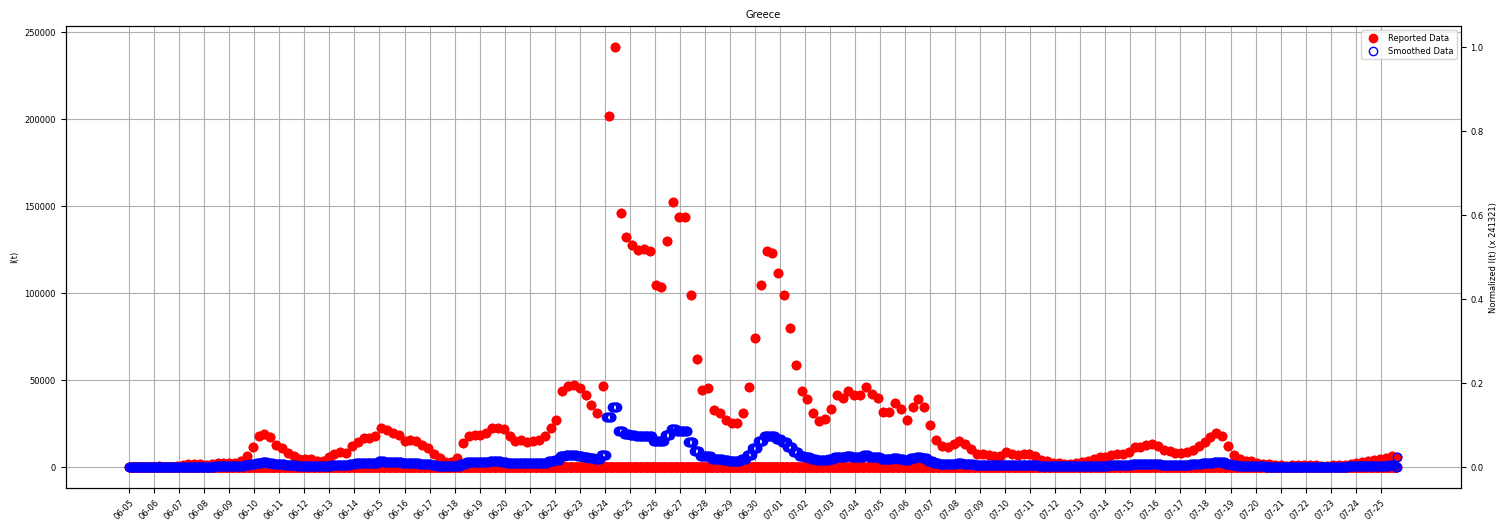

c:\Users\hanky\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loading pre-trained SIR model!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, None, 100)      │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, None, 100)      │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, None, 100)      │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, None, 100)      │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, None, 100)      │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, None, 1)        │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,701 (317.98 KB)

 Trainable params: 40,701 (317.98 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\hanky\AppData\Local\Temp\ipykernel_26576\4115363843.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log = "Epoch:%6i, N: %i, %s, S: %.6f, S0: %.6f, Mu: %.6f, R0:%.6f, P:%i" % (epoch + 1, N, " ".join("%s: %12.6f " % (k,v) for k,v in losses.items()), sigma.numpy(), sigma0.numpy(), mu.numpy(), sigma0.numpy()/mu.numpy(), self.wait)


Epoch:     1, N: 241321, MSE_Data:     8.960429  MSE_SIR:     0.048533  TotLoss:     9.008962 , S: 0.099000, S0: 0.099000, Mu: 0.099000, R0:1.000000, P:0


C:\Users\hanky\AppData\Local\Temp\ipykernel_26576\4115363843.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("%s. $\sigma$: %.6f $\sigma_0$: %.6f $\mu$: %.6f $R_0$: %.6f" % (country, self.bestSigma, self.bestSigma0, self.bestM, self.bestSigma0/self.bestM))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


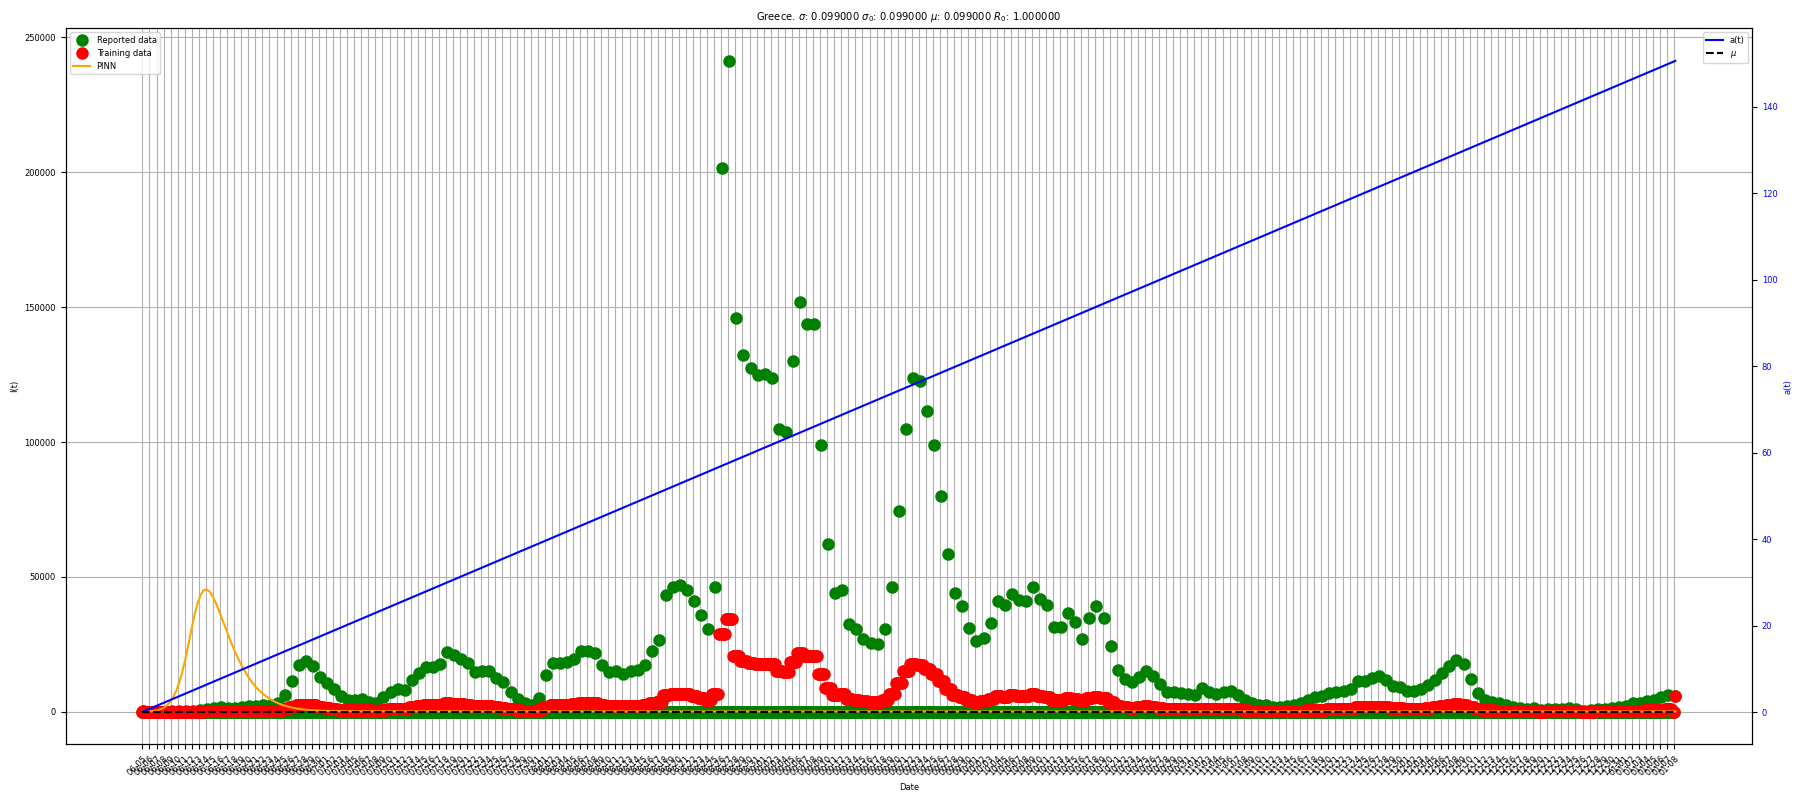

C:\Users\hanky\AppData\Local\Temp\ipykernel_26576\4115363843.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log = "Epoch:%6i, N: %i, %s, S: %.6f, S0: %.6f, Mu: %.6f, R0:%.6f, P:%i" % (epoch + 1, N, " ".join("%s: %12.6f " % (k,v) for k,v in losses.items()), sigma.numpy(), sigma0.numpy(), mu.numpy(), sigma0.numpy()/mu.numpy(), self.wait)


Epoch:     2, N: 241321, MSE_Data:     7.778529  MSE_SIR:     0.068319  TotLoss:     7.846848 , S: 0.098000, S0: 0.098000, Mu: 0.098000, R0:1.000000, P:0
Epoch:     3, N: 241321, MSE_Data:     6.740465  MSE_SIR:     0.093873  TotLoss:     6.834338 , S: 0.097000, S0: 0.097000, Mu: 0.097000, R0:1.000000, P:0
Epoch:     4, N: 241321, MSE_Data:     5.855569  MSE_SIR:     0.122197  TotLoss:     5.977766 , S: 0.096000, S0: 0.096000, Mu: 0.096000, R0:1.000000, P:0
Epoch:     5, N: 241321, MSE_Data:     5.120046  MSE_SIR:     0.150412  TotLoss:     5.270458 , S: 0.095000, S0: 0.095000, Mu: 0.095000, R0:1.000000, P:0
Epoch:     6, N: 241321, MSE_Data:     4.531288  MSE_SIR:     0.176742  TotLoss:     4.708030 , S: 0.094000, S0: 0.094000, Mu: 0.094000, R0:1.000000, P:0
Epoch:     7, N: 241321, MSE_Data:     4.085687  MSE_SIR:     0.198817  TotLoss:     4.284504 , S: 0.093000, S0: 0.093000, Mu: 0.093000, R0:1.000000, P:0
Epoch:     8, N: 241321, MSE_Data:     3.773386  MSE_SIR:     0.213875  TotL

C:\Users\hanky\AppData\Local\Temp\ipykernel_26576\4115363843.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("%s. $\sigma$: %.6f $\sigma_0$: %.6f $\mu$: %.6f $R_0$: %.6f" % (country, self.bestSigma, self.bestSigma0, self.bestM, self.bestSigma0/self.bestM))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


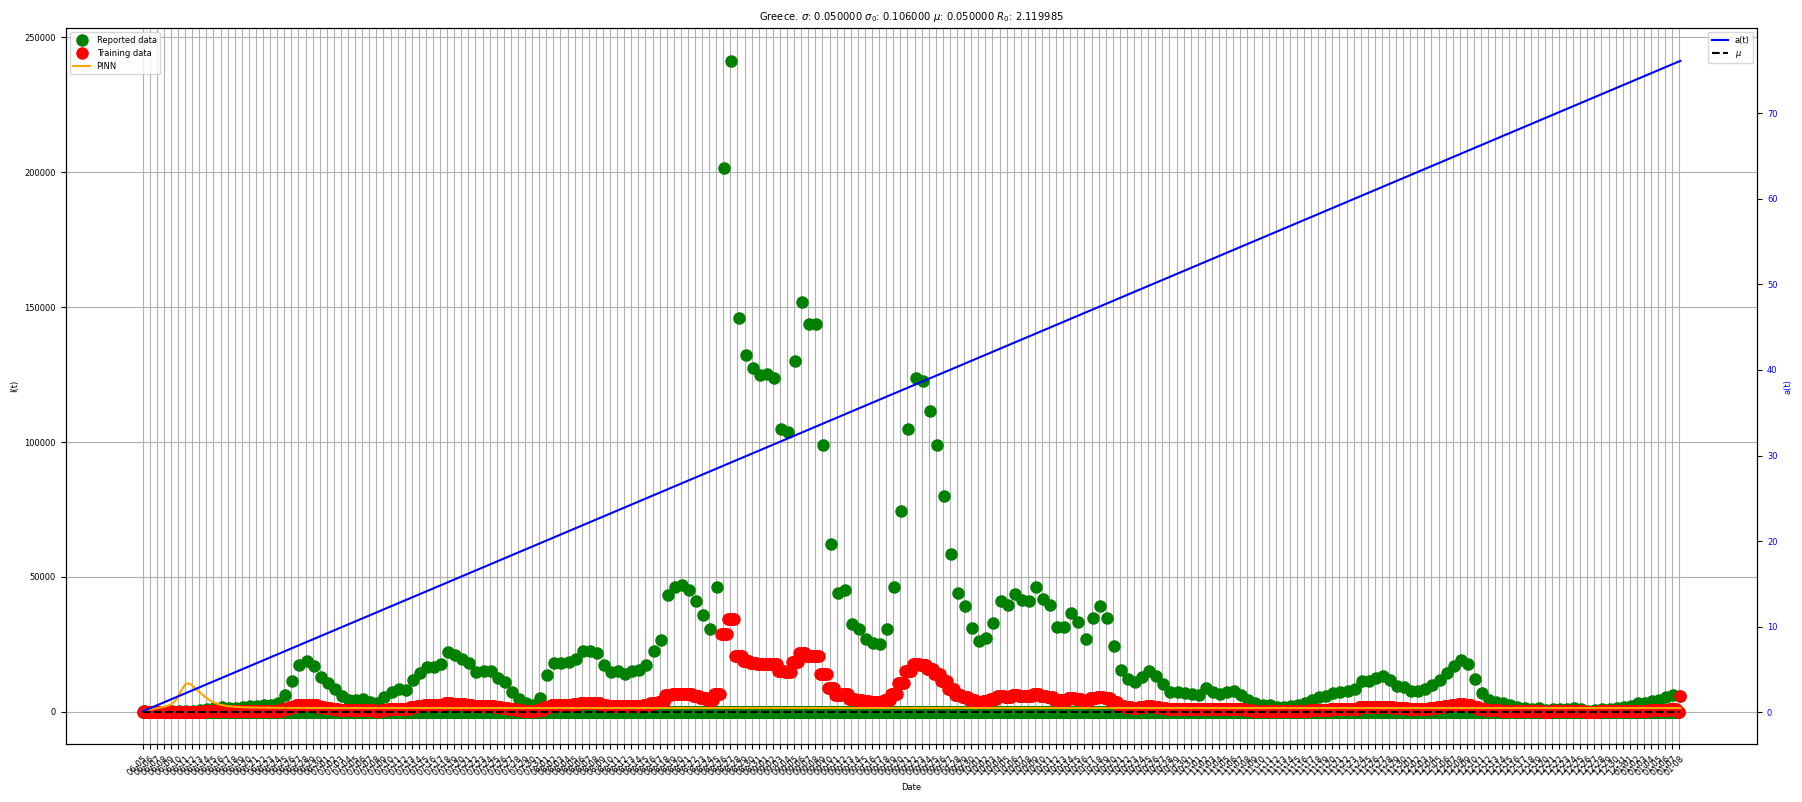

C:\Users\hanky\AppData\Local\Temp\ipykernel_26576\4115363843.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log = "Epoch:%6i, N: %i, %s, S: %.6f, S0: %.6f, Mu: %.6f, R0:%.6f, P:%i" % (epoch + 1, N, " ".join("%s: %12.6f " % (k,v) for k,v in losses.items()), sigma.numpy(), sigma0.numpy(), mu.numpy(), sigma0.numpy()/mu.numpy(), self.wait)


Epoch:    51, N: 241321, MSE_Data:     2.596153  MSE_SIR:     0.000334  TotLoss:     2.596487 , S: 0.049000, S0: 0.107000, Mu: 0.049000, R0:2.183657, P:0
Epoch:    52, N: 241321, MSE_Data:     2.591766  MSE_SIR:     0.000291  TotLoss:     2.592057 , S: 0.048000, S0: 0.108000, Mu: 0.048000, R0:2.249983, P:0
Epoch:    53, N: 241321, MSE_Data:     2.588035  MSE_SIR:     0.000253  TotLoss:     2.588288 , S: 0.047000, S0: 0.109000, Mu: 0.047000, R0:2.319130, P:0
Epoch:    54, N: 241321, MSE_Data:     2.584907  MSE_SIR:     0.000221  TotLoss:     2.585128 , S: 0.046000, S0: 0.110000, Mu: 0.046000, R0:2.391284, P:0
Epoch:    55, N: 241321, MSE_Data:     2.582293  MSE_SIR:     0.000193  TotLoss:     2.582486 , S: 0.045000, S0: 0.111000, Mu: 0.045000, R0:2.466645, P:0
Epoch:    56, N: 241321, MSE_Data:     2.580056  MSE_SIR:     0.000169  TotLoss:     2.580225 , S: 0.044000, S0: 0.112000, Mu: 0.044000, R0:2.545431, P:0
Epoch:    57, N: 241321, MSE_Data:     2.578008  MSE_SIR:     0.000149  TotL

C:\Users\hanky\AppData\Local\Temp\ipykernel_26576\4115363843.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("%s. $\sigma$: %.6f $\sigma_0$: %.6f $\mu$: %.6f $R_0$: %.6f" % (country, self.bestSigma, self.bestSigma0, self.bestM, self.bestSigma0/self.bestM))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


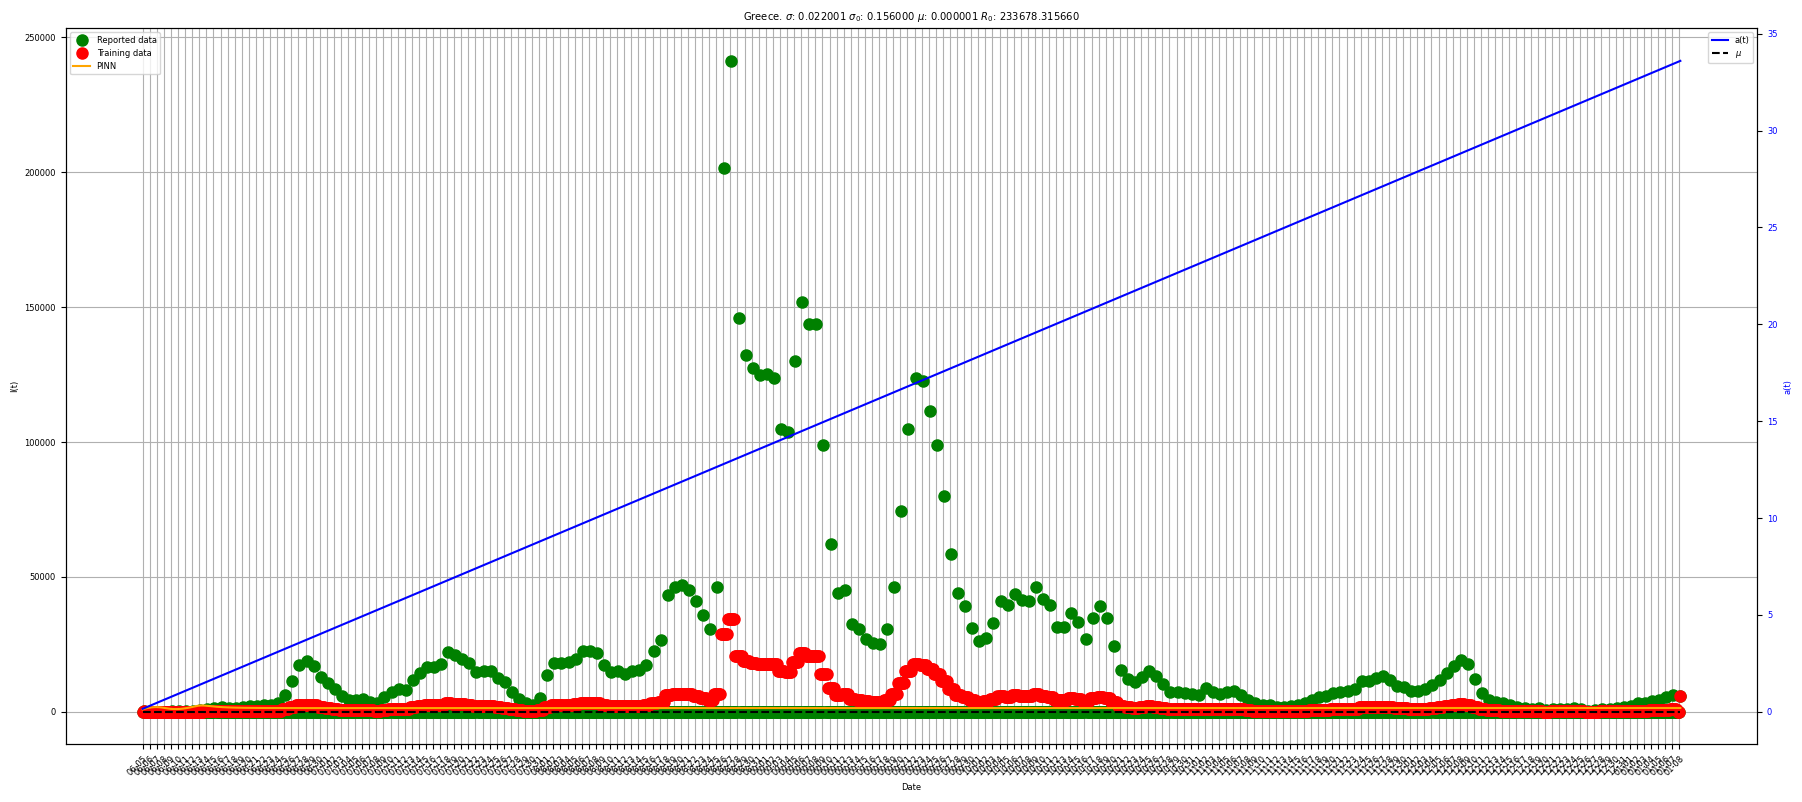

C:\Users\hanky\AppData\Local\Temp\ipykernel_26576\4115363843.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log = "Epoch:%6i, N: %i, %s, S: %.6f, S0: %.6f, Mu: %.6f, R0:%.6f, P:%i" % (epoch + 1, N, " ".join("%s: %12.6f " % (k,v) for k,v in losses.items()), sigma.numpy(), sigma0.numpy(), mu.numpy(), sigma0.numpy()/mu.numpy(), self.wait)


Epoch:   101, N: 241321, MSE_Data:     2.522114  MSE_SIR:     0.000003  TotLoss:     2.522117 , S: 0.023001, S0: 0.157000, Mu: 0.001001, R0:156.895924, P:0
Epoch:   102, N: 241321, MSE_Data:     2.521890  MSE_SIR:     0.000003  TotLoss:     2.521893 , S: 0.024001, S0: 0.158000, Mu: 0.000001, R0:236674.024367, P:0
Epoch:   103, N: 241321, MSE_Data:     2.521697  MSE_SIR:     0.000003  TotLoss:     2.521700 , S: 0.025001, S0: 0.159000, Mu: 0.001001, R0:158.894590, P:0
Epoch:   104, N: 241321, MSE_Data:     2.521512  MSE_SIR:     0.000003  TotLoss:     2.521515 , S: 0.026000, S0: 0.160000, Mu: 0.000001, R0:239669.886513, P:0
Epoch:   105, N: 241321, MSE_Data:     2.521319  MSE_SIR:     0.000003  TotLoss:     2.521322 , S: 0.027000, S0: 0.161000, Mu: 0.001001, R0:160.893255, P:0


KeyboardInterrupt: 

In [31]:
for country, params in countries.items() :
  #
  if country in runOnly :
    #
    # Index of the first day of the second wave.
    t0 = params["SWt0"]
    #
    # Make a folder for the given country.
    if not os.path.exists("SecondWave_%s" % country) : os.mkdir("SecondWave_%s" % country)
    #
    # Country's data
    cntryOriginal = data[data["location"] == country]
    #
    # Keep only the dates after the first case.
    cntryCases = cntryOriginal[kind][cntryOriginal["total_%s" % kind.split("_")[1]] > 0].values.astype("float64") # > 0:
    # Dates
    dates = cntryOriginal["date"][cntryOriginal["total_%s" % kind.split("_")[1]] > 0].values    
    #    
    # Fill gaps with ones.
    cntryCases[cntryCases < 1] = 1 # why gaps must be filled: https://www.youtube.com/watch?v=Kas0tIxDvrg
    #
    # Keep only the second wave.
    cntryCases = cntryCases[t0:]
    dates = dates[t0:]
    #
    # Add the current day cases.
    #cntryCases = np.append(cntryCases, 916)
    #
    # Number of days for the second wave.
    nOfDays = len(cntryCases)
    #
    # Keep date zero ( One day before the first date with non-zero cases ).
    dateZero = str(datetime.strptime(dates[0], '%Y-%m-%d') - timedelta(days = 1)).split()[0]
    #strptime: https://www.programiz.com/python-programming/datetime/strptime
    #timedelta(days = 1) means one day before the first date with non-zero cases
    #
    # and the last date.
    dateLast = str(datetime.strptime(dates[-1], '%Y-%m-%d') + timedelta(days = 1)).split()[0]
    #
    # Check for missing data and create Country's date labels.
    lastDateFound = False
    dateTicks = ["%s" % dateZero[5:]]
    #
    for d in range(1, nOfDays + nOfShortPredDays + nOfLongPredDays) :
      #
      nextDate = str(datetime.strptime(dateZero, '%Y-%m-%d') + timedelta(days = d)).split()[0]
      #
      if not lastDateFound :
        if nextDate not in dates :
          print ("Missing date", nextDate)
          cntryCases = np.insert(cntryCases, d, 0)
      #
      if nextDate == dates[-1] : lastDateFound = True
      #
      dateTicks.append("%s" % (nextDate[5:]))
    #
    # Time axis
    tData = np.linspace(0, nOfDays-1, nOfDays)
    #
    # Smooth and normalize the data.
    #
    # Min Max scaler.
    N0, N = 0, max(cntryCases)
    #
    # Smoothing.
    ItDataOr = cntryCases
    #
    ItData = []
    if nOfDaysSmoothing > 0 : ItData.extend(ItDataOr[:nOfDaysSmoothing])
    #
    ItData.extend([sum(ItDataOr[i-nOfDaysSmoothing:i+nOfDaysSmoothing+1])/(2*nOfDaysSmoothing+1) for i in range(nOfDaysSmoothing,len(ItDataOr)-nOfDaysSmoothing)])
    #
    if nOfDaysSmoothing > 0 : ItData.extend(ItDataOr[-nOfDaysSmoothing:])
    #
    # Smoothed data.
    ItData = np.array(ItData)
    #
    # Normalize.
    ItData = (ItData - N0)/(N-N0)
    ItDataOr = (ItDataOr - N0)/(N-N0)
    #
    # Plot the normalized data.
    fig, ax = plt.subplots( figsize = (18,6) )
    #
    plt.title(country)
    #
    # Plot the original data.
    ax.plot(tData, cntryCases, "ro")
    #
    ax.set_ylabel("I(t)")
    #
    # Plot the normalized and smoothed data.
    ax1 = ax.twinx()
    #
    ax1.plot(tData, ItDataOr, "ro", label = "Reported Data")
    ax1.plot(tData, ItData, "bo", fillstyle = "none", label = "Smoothed Data")
    #
    ax.grid()
    #
    ax1.set_xticks(tData[::30])
    ax1.set_xticklabels(dateTicks[:len(tData[::30])])
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    #
    ax1.set_ylabel("Normalized I(t) (x %i)" % N)
    plt.xlabel("Date")
    #
    plt.legend()
    plt.show()
    plt.close()    
    #
    # Initialize the random generator seed.
    np.random.seed(45)
    tf.random.set_seed(45)
    #

    # Trainig data.
    # Data driven.
    xTrain    = tData.reshape(-1,1)
    xt = np.log(ItData)
    yTrain    = xt.reshape(-1,1)

    # PINN.
    tSIR  = np.linspace(0, nOfDays-1, nOfSIRPoints+1)
    xTrainSIR = tSIR.reshape(-1,1)

    # Initialize the PINN-SIR variables
    sigma  = tf.Variable([0.1], dtype = "float64")
    sigma0 = tf.Variable([0.1], dtype = "float64")
    #
    mu = tf.Variable([0.1], dtype = "float64")
    #
    # Use pre-trained model.
    if loadModel :
      #
      if os.path.exists( "SecondWave_%s/%s_SIR.h5" % (country, country) ) :
        model = tf.keras.models.load_model("SecondWave_%s/%s_SIR.h5" % (country, country) )
        print("Loading pre-trained country's model!")
      else :
        #
        model = tf.keras.models.load_model('sim_SIR.h5')
        print("Loading pre-trained SIR model!")
      #
    # Train a model from scratch.
    else :
      #
      # Xavier normal initializer.
      initializer = tf.keras.initializers.GlorotNormal()
      #
      act = "sigmoid"
      model = Sequential()
      model.add(Dense( 100, input_shape = (1,), activation = act, kernel_initializer = initializer) )
      model.add(Dense( 100, activation = act, kernel_initializer = initializer ))
      model.add(Dense( 100, activation = act, kernel_initializer = initializer ))
      model.add(Dense( 100, activation = act, kernel_initializer = initializer ))
      model.add(Dense( 100, activation = act, kernel_initializer = initializer ))
      #
      model.add(Dense(1))
      #

    # Model's summary.
    model.summary()
    #
    
    # Create an optimizer using Adam.
    optimizer = tf.keras.optimizers.Adam()

    # Creat a Logger object.
    logger = EarlyStopping(model = model, patience = patience, displayStep = displayStep, 
                           realData  = (tData, ItDataOr),
                           trainData = (tData, xt),
                           tPredict  = tSIR)

    # Store losses.
    losses = []

    # Custom training loop.
    for epoch in range(epochs): 
      #
      with tf.GradientTape(persistent = True) as tape:
        #
        # Data driven.
        yPred = model(tData.reshape(-1, 1), training = True)
        #
        # Compute the MSE_{D} value.
        loss_valueMSE = loss_MSE(yTrain, yPred)
        #
        # Compute the MSE_{SIR}
        loss_valueSIR = loss_SIR()
        #
        # Compute the total Loss function.
        loss_value = loss_valueMSE + tf.reduce_mean(loss_valueSIR)
        
      # Retrieve the gradients of the trainable variables with respect to the loss.
      grads  = tape.gradient(loss_value, model.trainable_weights)
    
      # Apply the gradients.
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
  
      # Retrieve the gradients of the trainable variables with respect to the loss_SIR.
      gradsA = tape.gradient(loss_valueSIR, [sigma, sigma0, mu])
      
      # Create a new optimizer instance for the new variables.
      optimizer_new = tf.keras.optimizers.Adam()
      
      # Apply the gradients.  
      optimizer_new.apply_gradients(zip(gradsA, [sigma, sigma0, mu]))
      #    
      losses.append( float(tf.reduce_mean(loss_value)) )
      #
      stop_training = logger.on_epoch_end(epoch, {"MSE_Data": float(tf.reduce_mean(loss_valueMSE)),
                                                  "MSE_SIR" : float(tf.reduce_mean(loss_valueSIR)), 
                                                  "TotLoss" : float(tf.reduce_mean(loss_value))})
      #
      if stop_training : break